In [1]:
!nvidia-smi

Sun Dec 29 20:53:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8               2W / 140W |    165MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
def mul(*v):
    ret=1
    for x in v:
        ret*=x
    return ret

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm

from torchsummary import summary
from matplotlib import pyplot as plt
import numpy as np
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device("cpu") #gpu driver error, switch to cpu for now
device

device(type='cuda')

In [4]:
l = torchvision.datasets.MNIST(root='./mnist_data/', train = True, download = True, transform = transforms.ToTensor())
t = torchvision.datasets.MNIST(root='./mnist_data/', train = False, download = True, transform = transforms.ToTensor())

In [5]:
l.data.shape,l.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [6]:
l.data[0].shape,l.targets[0]

(torch.Size([28, 28]), tensor(5))

In [7]:
img_shape=tuple(l.data[0].shape)
img_dim=mul(*img_shape)
img_shape,img_dim

((28, 28), 784)

In [8]:
x_l=l.data.numpy()
y_l=l.targets.numpy()
x_t=t.data.numpy()
y_t=t.targets.numpy()

In [9]:
IMG_DTYPE=np.float32

#training set
yl=y_l #get selected imgs
xl=x_l.astype(IMG_DTYPE)/255 #color 0~255

#testing set
T_SIZE=1000
yt=y_t[:T_SIZE]
xt=x_t[:T_SIZE].astype(IMG_DTYPE)/255

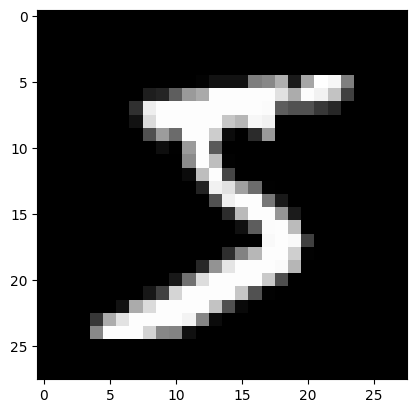

In [10]:
plt.imshow(xl[0], cmap='gray') 

In [11]:
L_BATCH_SIZE=64
T_BATCH_SIZE=100


#create dataloaders
ld=torch.utils.data.DataLoader(
    list(zip(xl,yl)),shuffle=True,batch_size=L_BATCH_SIZE
)
td=torch.utils.data.DataLoader(
    list(zip(xt,yt)),shuffle=True,batch_size=T_BATCH_SIZE
)

In [12]:
Z_DIM=16
MID_DIM=256
class VAE(nn.Module):
    def __init__(self,z_dim=Z_DIM,mid_dim=MID_DIM):
        super().__init__()
        self.fc1 = nn.Linear(img_dim, mid_dim)
        
        self.fc21 = nn.Linear(mid_dim,z_dim) #mu (mean)
        self.fc22 = nn.Linear(mid_dim, z_dim) #sigma (std)


        self.fc3 = nn.Linear(z_dim, mid_dim)
        self.fc4 = nn.Linear(mid_dim,img_dim)
        
    def encode(self,x):
        x=torch.relu(self.fc1(x))
        return self.fc21(x),self.fc22(x)

    def decode(self,x):
        return F.sigmoid(
            self.fc4(
                torch.relu(
                    self.fc3(x)
                )
            )
        )

    def forward(self, x):
        mu, log_std = self.encode(
            x.view(-1, img_dim)
        )
        std = torch.exp(log_std*0.5)
        e = torch.randn_like(std)
        return self.decode(mu+std*e),mu,std,log_std

In [13]:
def loss_fn(x, y, mu, std, log_std): 
    '''BCE + KLD'''
    return F.binary_cross_entropy(y, x.view(-1, img_dim), reduction='sum') *20 + \
        torch.sum(1 + log_std - mu**2 - std**2)* -0.5

In [14]:
model=VAE().to(device)
op=torch.optim.Adam(
    model.parameters(),
    lr=0.002
)

In [15]:
model

VAE(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc21): Linear(in_features=256, out_features=16, bias=True)
  (fc22): Linear(in_features=256, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=784, bias=True)
)

In [16]:
def l_step(
    model: torch.nn.Module,
    dl: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    op: torch.optim.Optimizer,
    epochs:int=50
):
    # Put model in train mode
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx,(x,_) in enumerate(dl):
            x=x.to(device)

            # 1. Forward pass
            y,mu,std,log_std = model(x)

            # 2. Caculate the loss
            loss=loss_fn(x,y,mu,std,log_std)

            # 3. Optimizer zero grad
            op.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            op.step()

            epoch_loss+=loss.item()
        
        if epoch%4==0:
            print(epoch_loss)
            
    model.eval()


In [17]:
l_step(
    model,
    ld,
    loss_fn,
    op,
    50
)

135573525.6328125
94184205.17578125
91280006.12890625
89904151.3515625
89004903.5234375
88398497.6953125
87970659.84765625
87625361.375
87296518.9609375
87085998.29296875
86860472.34375
86680859.5390625
86549062.015625


In [18]:
model.decode(torch.randn(Z_DIM).to(device)).cpu().detach().numpy()

array([5.89385046e-17, 4.85425582e-17, 4.87018865e-17, 6.27653267e-17,
       1.16366723e-16, 5.38733369e-17, 4.11811934e-17, 3.79619289e-17,
       9.27384875e-17, 2.89706113e-17, 4.55870783e-17, 4.29689359e-17,
       6.71209484e-31, 2.25202732e-33, 1.05923534e-25, 6.03849899e-25,
       8.31099530e-17, 1.07669680e-16, 7.20748077e-17, 6.05028289e-17,
       6.73841312e-17, 6.01521109e-17, 5.15645931e-17, 5.66559626e-17,
       1.06190628e-16, 6.20939869e-17, 4.81795020e-17, 5.46814394e-17,
       6.22450565e-17, 1.38043487e-16, 4.00951714e-17, 8.33677885e-17,
       1.34336400e-31, 1.90003100e-27, 1.15034241e-24, 1.13691678e-20,
       1.19334085e-32, 1.88811484e-36, 0.00000000e+00, 0.00000000e+00,
       2.17176491e-36, 4.46216921e-32, 1.38794175e-26, 4.79210027e-19,
       1.77231683e-13, 5.77609575e-13, 1.57685580e-15, 8.41164980e-19,
       1.50399561e-18, 1.23816457e-16, 1.05308498e-14, 3.83815609e-18,
       4.87887239e-17, 5.58565885e-17, 5.18300387e-17, 2.99240064e-17,
      

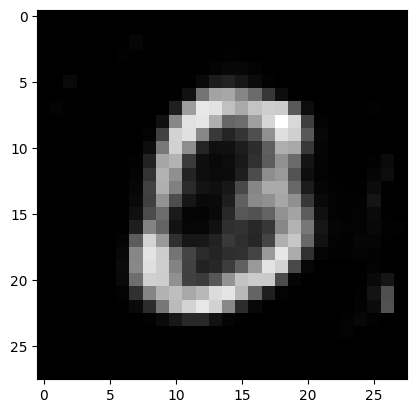

In [62]:
plt.imshow(model.decode((torch.randn(Z_DIM)/2).to(device)).cpu().view(*img_shape).detach().numpy(), cmap='gray') 